In [25]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Function to Get Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    # Drop rows with NaN values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    # Reset the index
    data.reset_index(inplace = True)
    return data

# Function Call
commodities_list = ['SIL=F', 'HG=F']
start_date = '2023-07-01'
end_date = '2024-07-01'
commod_data = import_commod_data(commodities_list, start_date, end_date)
print("Data Head:")
print(commod_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data Head:
        Date      SIL=F    HG=F
0 2023-07-03  22.896000  3.7790
1 2023-07-05  23.197001  3.7535
2 2023-07-06  22.686001  3.7200
3 2023-07-07  23.091999  3.7670
4 2023-07-10  23.150999  3.7715


In [26]:
### Function to Compute Spread
def compute_spread(stock1_data, stock2_data):
    # Taking the natural logarithm of the stock prices
    Y = np.log(stock2_data)
    X = np.log(stock1_data)
    # Adding a constant term to the independent variable (X) for the intercept
    X = sm.add_constant(X)
    # Fitting the Ordinary Least Squares (OLS) regression model
    model = sm.OLS(Y, X)
    results = model.fit()
    # Extracting the regression parameters alpha (intercept) and beta (slope)
    alpha = results.params.values[0]
    beta = results.params.values[1]

    # Calculating the spread (residuals) as the difference between the actual Y and the predicted Y
    errors = Y - (alpha + X.iloc[:, 1] * beta)
    
    return errors, alpha, beta

### Compute Spread
# Assume your data is structured with 'Close' columns for each commodity
stock1_data = commod_data[commodities_list[0]]
stock2_data = commod_data[commodities_list[1]]
# Compute Spread
spread, alpha, beta = compute_spread(stock1_data, stock2_data)
print(f"Regression parameters: alpha = {round(alpha, 4)}, beta = {round(beta, 4)}")
print("Spread Head:")
print(spread.head())


Regression parameters: alpha = -1.2523, beta = 0.8206
Spread Head:
0    0.012349
1   -0.005140
2    0.004175
3    0.002174
4    0.001273
dtype: float64


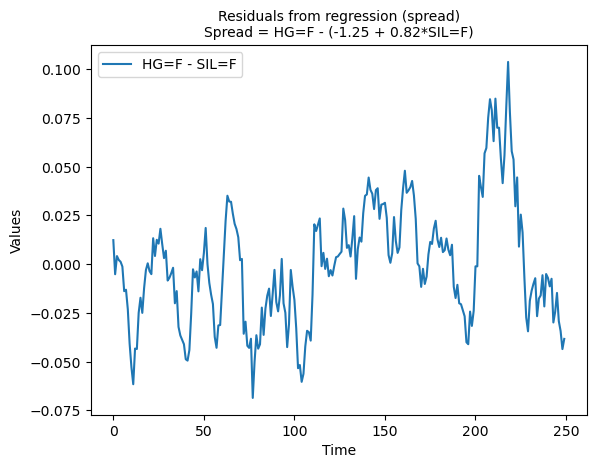

In [27]:
### Plotting the Spread
commod1_name = commodities_list[0]
commod2_name = commodities_list[1]

spread.plot(label=f"{commod2_name} - {commod1_name}")
plt.title(f'Residuals from regression (spread)\nSpread = {commod2_name} - ({alpha:.2f} + {beta:.2f}*{commod1_name})', fontsize=10)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


In [28]:
### Implement the ADF Test
def adf_test(spread):
    # Performing the Augmented Dickey-Fuller test on the provided series
    result = adfuller(spread.dropna())

    print("Results of Dickey-Fuller Test:")
    print('ADF Statistic:', round(result[0], 4))
    print('p-value:', round(result[1], 4))
    print('Number of Lags Used:', round(result[2], 4))
    print('Number of Observations Used:', round(result[3], 4))

    # Printing the critical values for the test statistic at different significance levels
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {round(value, 4)}')
    # Printing the Maximized Information Criterion (AIC)
    print('Maximized Information Criterion (AIC):', round(result[5], 4))

    # Interpreting the p-value to determine stationarity
    p_val = result[1]
    if p_val < 0.05:
        print(f'Since the p value of: {round(p_val, 4)} < 0.05, we reject the null hypothesis and conclude the data is stationary')
    else:
        print(f'Since the p value of: {round(p_val, 4)} > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary')

    # Interpretation of ADF Statistic relative to Critical Values
    adf_stat = result[0]
    critical_values = result[4]
    print(f"Note that the Dickey-Fuller test result {round(adf_stat, 4)} lays between the critical values:")
    if adf_stat < critical_values['1%']:
        print("The test statistic is less than the 1% critical value; therefore, we reject the null hypothesis at the 1% level, concluding the data is stationary at the 1% significance level.")
    elif adf_stat < critical_values['5%']:
        print("The test statistic is less than the 5% critical value; therefore, we reject the null hypothesis at the 5% level, concluding the data is stationary at the 5% significance level.")
    elif adf_stat < critical_values['10%']:
        print("The test statistic is less than the 10% critical value; therefore, we reject the null hypothesis at the 10% level, concluding the data is stationary at the 10% significance level.")
    else:
        print("The test statistic is greater than the 10% critical value; therefore, we fail to reject the null hypothesis, concluding the data is non-stationary at the 10%, 5%, and 1% significance levels.")

### Perform Dickey-Fuller Test on Spread
adf_test(spread)


Results of Dickey-Fuller Test:
ADF Statistic: -3.8778
p-value: 0.0022
Number of Lags Used: 5
Number of Observations Used: 244
Critical Values:
   1%: -3.4574
   5%: -2.8735
   10%: -2.5731
Maximized Information Criterion (AIC): -1379.6572
Since the p value of: 0.0022 < 0.05, we reject the null hypothesis and conclude the data is stationary
Note that the Dickey-Fuller test result -3.8778 lays between the critical values:
The test statistic is less than the 1% critical value; therefore, we reject the null hypothesis at the 1% level, concluding the data is stationary at the 1% significance level.


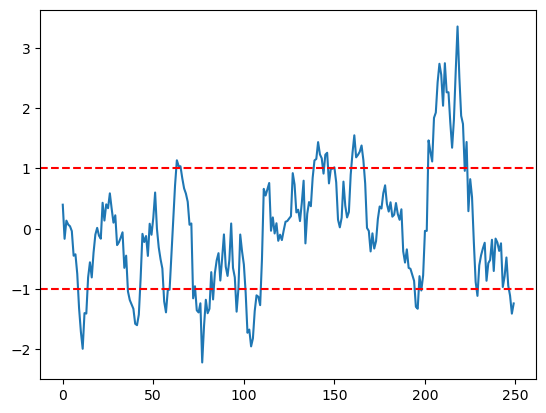

Z-score Head:
0    0.399272
1   -0.166174
2    0.134990
3    0.070276
4    0.041172
dtype: float64


In [29]:
### Compute the Z-score and Plot
def compute_zscore(spread):
    # Calculating the mean and standard deviation of the spread
    mean = spread.mean()
    stddev = spread.std()
    # Calculating the Z-score of the spread
    zscore = (spread - mean) / stddev

    # Plotting the Z-score
    zscore.plot()
    # Adding horizontal lines at Z-score = 1, Z-score = -1, and Z-score = 0
    plt.axhline(1, color='r', linestyle='--')
    plt.axhline(-1, color='r', linestyle='--')
    plt.show()

    return zscore

zscore = compute_zscore(spread)
print("Z-score Head:")
print(zscore.head())


In [30]:
### Create Signals Function
def signals(zscore, commod_data, signal_entry, signal_exit):
    # Ensure zscore is aligned with commod_data by setting the same index
    zscore.index = commod_data.index
    
    # Empty DataFrame to store signals
    signals_df = pd.DataFrame()
    # Populate the DataFrame with the signals
    signals_df = commod_data.copy()
    # Generate short signals
    signals_df['short_signal'] = (zscore > signal_entry) & (zscore.shift(1) <= signal_entry)
    signals_df['short_exit'] = (zscore < signal_exit) & (zscore.shift(1) >= signal_exit)
    # Generate long signals
    signals_df['long_signal'] = (zscore < -signal_entry) & (zscore.shift(1) >= -signal_entry)
    signals_df['long_exit'] = (zscore > -signal_exit) & (zscore.shift(1) <= -signal_exit)
    
    return signals_df[['short_signal', 'short_exit', 'long_signal', 'long_exit']]

signals_df = signals(zscore, commod_data, signal_entry = 1, signal_exit = -1)
print(signals_df.tail())
signals_df.to_csv('signals.csv')


     short_signal  short_exit  long_signal  long_exit
245         False       False        False      False
246         False       False        False      False
247         False        True         True      False
248         False       False        False      False
249         False       False        False      False


In [31]:
### Perform Backtesting
def perform_backtest(signals_df, commod_data):
    backtest_result = []
    spread_side = None  # This variable tracks the current position type: 'short', 'long', or None
    counter = -1  # This is used to help index the previous data point since DataFrame.iterrows() does not naturally handle this

    for time, signals_stock in signals_df.iterrows():
        counter += 1
        # Extracting signal data from the current row
        short_signal = signals_stock['short_signal']
        short_exit = signals_stock['short_exit']
        long_signal = signals_stock['long_signal']
        long_exit = signals_stock['long_exit']

        # Implementing the logic to calculate returns based on the position
        if spread_side == "long":
            # Calculate returns if in a long position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1
                return_hg_f = -(commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1)
            if long_exit:
                spread_side = None  # Exit long position
        elif spread_side == "short":
            # Calculate returns if in a short position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = -(commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1)
                return_hg_f = commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1
            if short_exit:
                spread_side = None  # Exit short position
        else:
            return_sil_f = 0
            return_hg_f = 0
            # Determine whether to start a new long or short position
            if short_signal:
                spread_side = "short"
            elif long_signal:
                spread_side = "long"

        # Append the results for this iteration to the list
        backtest_result.append([time, return_sil_f, return_hg_f, spread_side or "None"])

    # Create DataFrame from results
    backtest_df = pd.DataFrame(backtest_result, columns=['Time', 'Return_SIL=F', 'Return_HG=F', 'Spread_Side'])
    return backtest_df

backtest_result = perform_backtest(signals_df, commod_data)
print("\nBacktest Result Head:")
print(backtest_result.tail())



Backtest Result Head:
     Time  Return_SIL=F  Return_HG=F Spread_Side
245   245      0.000000     0.000000        None
246   246      0.000000     0.000000        None
247   247      0.000000     0.000000        long
248   248      0.000311     0.008930        long
249   249      0.011031    -0.014324        long


                               Date  Return_SIL=F  Return_HG=F  Side  Total_PL
Date                                                                          
1970-01-01 00:00:00.000000245   245      0.000000     0.000000  None -0.383426
1970-01-01 00:00:00.000000246   246      0.000000     0.000000  None -0.383426
1970-01-01 00:00:00.000000247   247      0.000000     0.000000  long -0.383426
1970-01-01 00:00:00.000000248   248      0.000311     0.008930  long -0.377727
1970-01-01 00:00:00.000000249   249      0.011031    -0.014324  long -0.379874


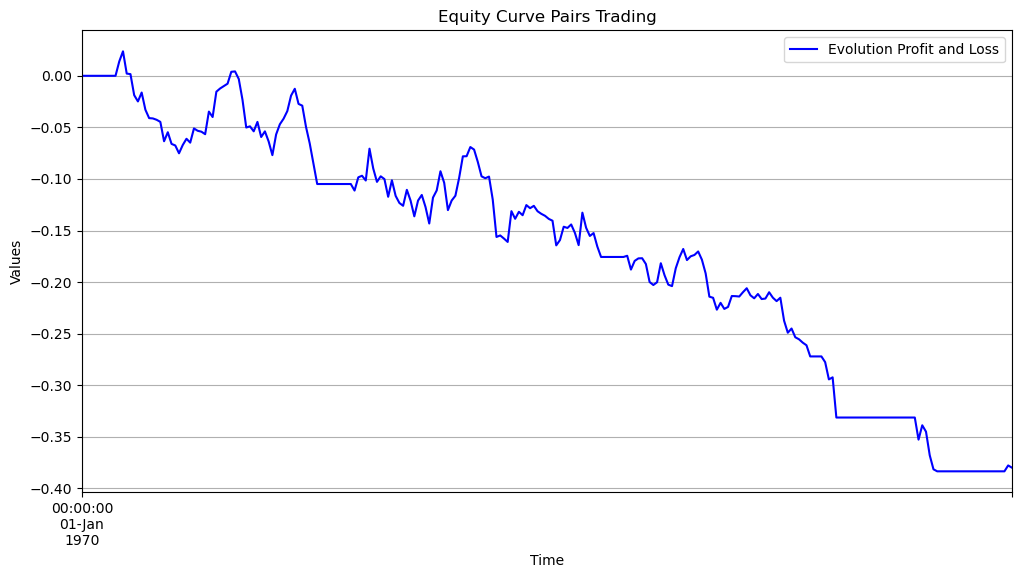

In [32]:
### Calculate Cululative Returns and Plot
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ['Date', 'Return_SIL=F', 'Return_HG=F', 'Side']
backtest_pandas['Return_SIL=F'] = backtest_pandas['Return_SIL=F'].astype(float)
backtest_pandas['Return_HG=F'] = backtest_pandas['Return_HG=F'].astype(float)
backtest_pandas['Total_PL'] = (1 + backtest_pandas['Return_SIL=F']).cumprod() * (1 + backtest_pandas['Return_HG=F']).cumprod() - 1
backtest_pandas.index = pd.to_datetime(backtest_pandas['Date'])
plt.figure(figsize=(12, 6))
backtest_pandas['Total_PL'].plot(label='Evolution Profit and Loss', color='blue')
print(backtest_pandas.tail(5))
plt.title('Equity Curve Pairs Trading')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Data Head:
        Date      SIL=F    HG=F
0 2024-01-02  23.733000  3.8690
1 2024-01-03  22.945999  3.8475
2 2024-01-04  22.989000  3.8310
3 2024-01-05  23.122000  3.7945
4 2024-01-08  23.120001  3.7995
Regression parameters: alpha = -1.0121, beta = 0.7513
Spread Head:
0   -0.014144
1    0.005619
2   -0.000085
3   -0.013993
4   -0.012611
dtype: float64
Results of Dickey-Fuller Test:
ADF Statistic: -2.0751
p-value: 0.2546
Number of Lags Used: 0
Number of Observations Used: 123
Critical Values:
   1%: -3.4847
   5%: -2.8853
   10%: -2.5795
Maximized Information Criterion (AIC): -656.2287
Since the p value of: 0.2546 > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary
Note that the Dickey-Fuller test result -2.0751 lays between the critical values:
The test statistic is greater than the 10% critical value; therefore, we fail to reject the null hypothesis, concluding the data is non-stationary at the 10%, 5%, and 1% significance levels.
Z-score Head:
0   -


Backtest Result Head:
     Time  Return_SIL=F  Return_HG=F Spread_Side
119   119     -0.002840    -0.007343        long
120   120     -0.022110     0.032251        long
121   121      0.002497     0.003082        long
122   122      0.000311     0.008930        long
123   123      0.011031    -0.014324        long
                               Date  Return_SIL=F  Return_HG=F  Side  Total_PL
Date                                                                          
1970-01-01 00:00:00.000000119   119     -0.002840    -0.007343  long -0.177134
1970-01-01 00:00:00.000000120   120     -0.022110     0.032251  long -0.169376
1970-01-01 00:00:00.000000121   121      0.002497     0.003082  long -0.164736
1970-01-01 00:00:00.000000122   122      0.000311     0.008930  long -0.157015
1970-01-01 00:00:00.000000123   123      0.011031    -0.014324  long -0.159924


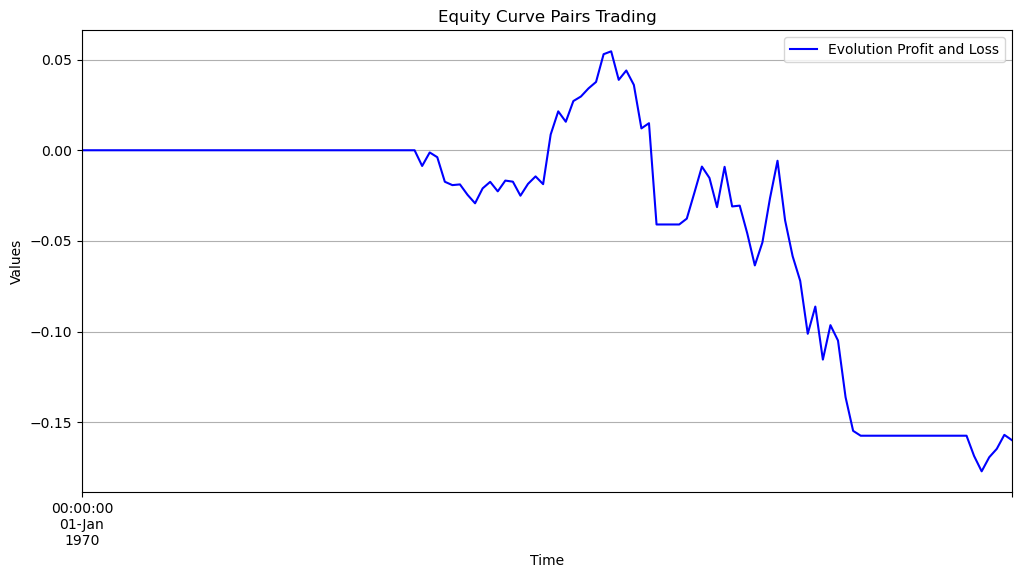

In [33]:
### Library Imports
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

### Function to Get Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end=end_date)['Adj Close']
    # Drop rows with NaN values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    # Reset the index
    data.reset_index(inplace=True)
    return data

### Function to Compute Spread
def compute_spread(stock1_data, stock2_data):
    # Taking the natural logarithm of the stock prices
    Y = np.log(stock2_data)
    X = np.log(stock1_data)
    # Adding a constant term to the independent variable (X) for the intercept
    X = sm.add_constant(X)
    # Fitting the Ordinary Least Squares (OLS) regression model
    model = sm.OLS(Y, X)
    results = model.fit()
    # Extracting the regression parameters alpha (intercept) and beta (slope)
    alpha = results.params.values[0]
    beta = results.params.values[1]

    # Calculating the spread (residuals) as the difference between the actual Y and the predicted Y
    errors = Y - (alpha + X.iloc[:, 1] * beta)
    
    return errors, alpha, beta

### Implement the ADF Test
def adf_test(spread):
    # Performing the Augmented Dickey-Fuller test on the provided series
    result = adfuller(spread.dropna())

    print("Results of Dickey-Fuller Test:")
    print('ADF Statistic:', round(result[0], 4))
    print('p-value:', round(result[1], 4))
    print('Number of Lags Used:', round(result[2], 4))
    print('Number of Observations Used:', round(result[3], 4))

    # Printing the critical values for the test statistic at different significance levels
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {round(value, 4)}')
    # Printing the Maximized Information Criterion (AIC)
    print('Maximized Information Criterion (AIC):', round(result[5], 4))

    # Interpreting the p-value to determine stationarity
    p_val = result[1]
    if p_val < 0.05:
        print(f'Since the p value of: {round(p_val, 4)} < 0.05, we reject the null hypothesis and conclude the data is stationary')
    else:
        print(f'Since the p value of: {round(p_val, 4)} > 0.05, we fail to reject the null hypothesis and conclude the data is non-stationary')

    # Interpretation of ADF Statistic relative to Critical Values
    adf_stat = result[0]
    critical_values = result[4]
    print(f"Note that the Dickey-Fuller test result {round(adf_stat, 4)} lays between the critical values:")
    if adf_stat < critical_values['1%']:
        print("The test statistic is less than the 1% critical value; therefore, we reject the null hypothesis at the 1% level, concluding the data is stationary at the 1% significance level.")
    elif adf_stat < critical_values['5%']:
        print("The test statistic is less than the 5% critical value; therefore, we reject the null hypothesis at the 5% level, concluding the data is stationary at the 5% significance level.")
    elif adf_stat < critical_values['10%']:
        print("The test statistic is less than the 10% critical value; therefore, we reject the null hypothesis at the 10% level, concluding the data is stationary at the 10% significance level.")
    else:
        print("The test statistic is greater than the 10% critical value; therefore, we fail to reject the null hypothesis, concluding the data is non-stationary at the 10%, 5%, and 1% significance levels.")

### Compute the Z-score and Plot
def compute_zscore(spread):
    # Calculating the mean and standard deviation of the spread
    mean = spread.mean()
    stddev = spread.std()
    # Calculating the Z-score of the spread
    zscore = (spread - mean) / stddev

    # Plotting the Z-score
    #zscore.plot()
    # Adding horizontal lines at Z-score = 1, Z-score = -1, and Z-score = 0
    #plt.axhline(1, color='r', linestyle='--')
    #plt.axhline(-1, color='r', linestyle='--')
    #plt.show()

    return zscore

### Create Signals Function
def signals(zscore, commod_data, signal_entry, signal_exit):
    zscore.index = commod_data.index
    signals_df = pd.DataFrame()
    signals_df = commod_data.copy()
    signals_df['short_signal'] = (zscore > signal_entry) & (zscore.shift(1) <= signal_entry)
    signals_df['short_exit'] = (zscore < signal_exit) & (zscore.shift(1) >= signal_exit)
    signals_df['long_signal'] = (zscore < -signal_entry) & (zscore.shift(1) >= -signal_entry)
    signals_df['long_exit'] = (zscore > -signal_exit) & (zscore.shift(1) <= -signal_exit)
    return signals_df[['short_signal', 'short_exit', 'long_signal', 'long_exit']]

### Perform Backtesting
def perform_backtest(signals_df, commod_data):
    backtest_result = []
    spread_side = None  # This variable tracks the current position type: 'short', 'long', or None
    counter = -1  # This is used to help index the previous data point since DataFrame.iterrows() does not naturally handle this

    for time, signals_stock in signals_df.iterrows():
        counter += 1
        # Extracting signal data from the current row
        short_signal = signals_stock['short_signal']
        short_exit = signals_stock['short_exit']
        long_signal = signals_stock['long_signal']
        long_exit = signals_stock['long_exit']

        # Implementing the logic to calculate returns based on the position
        if spread_side == "long":
            # Calculate returns if in a long position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1
                return_hg_f = -(commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1)
            if long_exit:
                spread_side = None  # Exit long position
        elif spread_side == "short":
            # Calculate returns if in a short position
            if counter > 0:  # Ensure there is a previous row to compare with
                return_sil_f = -(commod_data.iloc[counter]['SIL=F'] / commod_data.iloc[counter - 1]['SIL=F'] - 1)
                return_hg_f = commod_data.iloc[counter]['HG=F'] / commod_data.iloc[counter - 1]['HG=F'] - 1
            if short_exit:
                spread_side = None  # Exit short position
        else:
            return_sil_f = 0
            return_hg_f = 0
            # Determine whether to start a new long or short position
            if short_signal:
                spread_side = "short"
            elif long_signal:
                spread_side = "long"

        # Append the results for this iteration to the list
        backtest_result.append([time, return_sil_f, return_hg_f, spread_side or "None"])

    # Create DataFrame from results
    backtest_df = pd.DataFrame(backtest_result, columns=['Time', 'Return_SIL=F', 'Return_HG=F', 'Spread_Side'])
    return backtest_df


### Function Calls
commodities_list = ['SIL=F', 'HG=F']
start_date = '2024-01-01'
end_date = '2024-07-01'
commod_data = import_commod_data(commodities_list, start_date, end_date)
print("Data Head:")
print(commod_data.head())

# Assume your data is structured with 'Close' columns for each commodity
stock1_data = commod_data[commodities_list[0]]
stock2_data = commod_data[commodities_list[1]]
# Compute Spread
spread, alpha, beta = compute_spread(stock1_data, stock2_data)
print(f"Regression parameters: alpha = {round(alpha, 4)}, beta = {round(beta, 4)}")
print("Spread Head:")
print(spread.head())

# Perform Dickey-Fuller Test on Spread
adf_test(spread)

zscore = compute_zscore(spread)
print("Z-score Head:")
print(zscore.head())

signals_df = signals(zscore, commod_data, signal_entry=1, signal_exit=-1)
print(signals_df.tail())

backtest_result = perform_backtest(signals_df, commod_data)
print("\nBacktest Result Head:")
print(backtest_result.tail())

# Calculate returns and plot
backtest_pandas = pd.DataFrame(backtest_result)
backtest_pandas.columns = ['Date', 'Return_SIL=F', 'Return_HG=F', 'Side']
backtest_pandas['Return_SIL=F'] = backtest_pandas['Return_SIL=F'].astype(float)
backtest_pandas['Return_HG=F'] = backtest_pandas['Return_HG=F'].astype(float)
backtest_pandas['Total_PL'] = (1 + backtest_pandas['Return_SIL=F']).cumprod() * (1 + backtest_pandas['Return_HG=F']).cumprod() - 1
backtest_pandas.index = pd.to_datetime(backtest_pandas['Date'])
plt.figure(figsize=(12, 6))
backtest_pandas['Total_PL'].plot(label='Evolution Profit and Loss', color='blue')
print(backtest_pandas.tail(5))
plt.title('Equity Curve Pairs Trading')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()
